<a href="https://colab.research.google.com/github/kussy29/machine_learning/blob/main/lab02_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 - Unsupervised Learning: Clustering


### Author: Szymon Nowakowski



# Introduction
--------------------------------

Suppose $X$ represents tabular data:

$$
\begin{array}{c@{\hspace{1em}}c}
   & \text{Columns = Features} \\
   & \downarrow \\[-6pt]
\text{Rows = Observations (Data Points)} \; \longrightarrow
   &
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1k} \\
x_{21} & x_{22} & \dots & x_{2k} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nk}
\end{bmatrix}
\end{array}
$$

In this lab, we will explore clustering, a technique closely related to Principal Component Analysis. While PCA serves to identify directions in feature space (*columns* of the data matrix $X$), clustering identifies clusters of similarity in *rows* of $X$.




Clustering organizes data points based on shared characteristics, complementing PCA's emphasis on dimensionality reduction and feature extraction.

Clustering is a fundamental concept in **unsupervised learning**, a type of learning that deals with unstructured data without predefined labels. Clustering mirrors how children naturally learn to make sense of the world around them. When children are born, they lack pre-labeled categories for the objects they encounter. Instead, they observe and group similar things based on shared characteristics—like shapes, colors, or textures. For example, they might cluster soft, round objects as "balls" or distinguish people by recurring patterns such as faces and voices. This intuitive grouping process helps them organize the overwhelming complexity of their environment into meaningful categories, much like clustering algorithms organize unstructured data into clusters without prior labels.

# Evaluating Clustering Quality
--------------------------------

## Intuitive Principles

Clustering is an unsupervised learning technique that organizes data points into groups based on their similarity or dissimilarity, without the need for predefined labels. While we often have an intuitive sense of what constitutes good clustering, it typically boils down to two key principles:

- Similar points should be grouped together in the same cluster (**compactness**). In other words, we expect the within cluster variance to be low.
- Distinct points should be placed in separate clusters (**separation**). We expect the between cluster variance to be high.

Beyond these basic notions, clustering as a machine learning method is surprisingly loosely defined!

## Evaluation Metrics

To assess the quality of clustering, we rely on metrics that capture the intrinsic properties of clusters, emphasizing both compactness and separation. These metrics translate our intuitive principles into measurable criteria for evaluating how well a clustering algorithm performs.

### 1. Silhouette Score

The silhouette score (*pl. wartość* lub *wskaźnik sylwetki*) assesses the balance between cluster compactness and separation. For a single point $i$, the silhouette value is:

$$ s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))} $$

where:

- $a(i)$ is the average distance between $i$ and all other points in the same cluster. It measures *compactness* of $i$, i.e. how close the point is to others in its own cluster.
- $b(i)$ is the minimum average distance between $i$ and the points in the  neighboring cluster (minimum average distance makes this cluster the nearest). It measures *separation* of $i$, i.e. how far the point is from points in the nearest cluster.

For each point, the silhouette value measures the difference between compactness and separation.

The silhouette value is then normalized and ranges between $-1$ and $1$:

- $s(i) \approx 1$: The point is **well-clustered**, meaning it is close to points in its own cluster and far from points in other clusters.
- $s(i) \approx 0$: The point is on or **near the boundary between clusters**.
- $s(i) \approx -1$: The point is likely **misclassified**, as it is closer to a different cluster than to the cluster it was assigned.

The overall silhouette score for the clustering is the mean silhouette value across all points:

$$ S = \frac{1}{n} \sum_{i=1}^n s(i) $$

Values close to $1$ indicate well-separated and compact clusters, while values near $0$ or negative suggest overlapping clusters.


### 2. Inertia, or Within-Cluster Sum of Squares (SS)
Inertia measures the compactness of clusters by summing the squared distances of points to their assigned cluster centroid: $ \text{Inertia} = \sum_{k=1}^K \sum_{i \in C_k} ||x_i - \mu_k||^2 $ where:

$K$ is the number of clusters.
$C_k$ is the set of points in cluster $k$.
$\mu_k$ is the centroid of cluster $k$.
$||x_i - \mu_k||^2$ is the squared Euclidean distance between point $x_i$ and the centroid $\mu_k$.

Lower inertia values indicate tighter, more compact clusters.



### Other metrics

There are other metrics. The difference is how the between cluster variance (separation) and within cluster variance (compactness) are estimated and on normalization schemes. The examples are:

1. Calinski-Harabasz Index
2. Davies-Bouldin Index
3. Dunn Index


# EM algorithm
--------------------------------



## Setup

- Let $\mathbf{X} = \{x_1,\dots,x_N\}$ be observed data.
- Let $\mathbf{Z} = \{z_1,\dots,z_N\}$ be latent (hidden) variables.
- Let $\theta$ be the model parameters (for example, mixture weights, means, covariances in a GMM).
- The (incomplete) likelihood of the data is
$$
p(\mathbf{X} \mid \theta) \;=\; \sum_{\mathbf{Z}} p(\mathbf{X}, \mathbf{Z} \mid \theta).
$$


## ELBO

We define an arbitrary distribution $q(\mathbf{Z})$ over the latent variables. Then we construct the **Evidence Lower BOund** (ELBO):

$$
\mathcal{L}(q,\theta)
\;=\;
\sum_{\mathbf{Z}} \;q(\mathbf{Z})
\;\log \frac{p(\mathbf{X}, \mathbf{Z} \mid \theta)}{q(\mathbf{Z})}.
$$

We want to show:


$$
\log p(\mathbf{X} \mid \theta)
\;=\;
\mathcal{L}(q,\theta)
\;+\;
\mathrm{KL}\!\Bigl(q(\mathbf{Z}) \,\bigl\|\; p(\mathbf{Z}\mid \mathbf{X}, \theta)\Bigr).
$$

Since the KL divergence is $\ge 0$, it follows that

$$
\log p(\mathbf{X} \mid \theta)
\;\ge\;
\mathcal{L}(q,\theta).
$$

### ELBO Inequality Derivation

**Step 1: Write $\log p(\mathbf{X}\mid\theta)$ as an expectation under $q(\mathbf{Z})$.**

Because
$$
\sum_{\mathbf{Z}} q(\mathbf{Z}) \;=\; 1,
$$
we have

$$
\log p(\mathbf{X}\mid \theta)
\;=\;
\sum_{\mathbf{Z}} q(\mathbf{Z}) \,\log p(\mathbf{X}\mid \theta).
$$


**Step 2: Rewrite the inside of the sum.**

$$
\frac{p(\mathbf{X},\mathbf{Z} \mid \theta)}{p(\mathbf{X}\mid \theta)}
\;=\;
p(\mathbf{Z}\mid\mathbf{X},\theta).
$$

so

$$
p(\mathbf{X}\mid \theta)
\;=\;
\frac{p(\mathbf{X},\mathbf{Z} \mid \theta)}{p(\mathbf{Z}\mid\mathbf{X},\theta)}
,
$$

and in terms of logarithms

$$
\log{p(\mathbf{X}\mid \theta)}
\;=\;
\log{p(\mathbf{X},\mathbf{Z} \mid \theta)} - \log{p(\mathbf{Z}\mid\mathbf{X},\theta)}
.
$$


We use it to rewrite $
\log p(\mathbf{X}\mid \theta)
\;=\;
\sum_{\mathbf{Z}} q(\mathbf{Z}) \,\log p(\mathbf{X}\mid \theta)
$:

$$
\log p(\mathbf{X}\mid \theta)
\;=\;
\sum_{\mathbf{Z}} q(\mathbf{Z})\,\bigl[\log p(\mathbf{X},\mathbf{Z}\mid \theta) - \log p(\mathbf{Z}\mid \mathbf{X},\theta)\bigr].
$$

Add and subtract $\log q(\mathbf{Z})$:

$$
\log p(\mathbf{X}\mid \theta)
\;=\;
\sum_{\mathbf{Z}} q(\mathbf{Z})
\Bigl[
\log p(\mathbf{X},\mathbf{Z}\mid \theta) - \log q(\mathbf{Z})
\;+\;
\log q(\mathbf{Z}) - \log p(\mathbf{Z}\mid \mathbf{X},\theta)
\Bigr].
$$

**Step 3: Separate into ELBO and KL divergence.**

Group them:

- ELBO part:
$$
\sum_{\mathbf{Z}} q(\mathbf{Z}) \;\log \frac{p(\mathbf{X},\mathbf{Z}\mid \theta)}{q(\mathbf{Z})},
$$

- KL part:
$$
\sum_{\mathbf{Z}} q(\mathbf{Z})\;\log \frac{q(\mathbf{Z})}{p(\mathbf{Z}\mid \mathbf{X},\theta)}
\;=\;
\mathrm{KL}\bigl(q(\mathbf{Z}) \,\|\, p(\mathbf{Z}\mid \mathbf{X},\theta)\bigr).
$$

Hence,

$$
\log p(\mathbf{X}\mid \theta)
\;=\;
\underbrace{\sum_{\mathbf{Z}} q(\mathbf{Z}) \,\log \frac{p(\mathbf{X}, \mathbf{Z}\mid \theta)}{q(\mathbf{Z})}}_{\mathcal{L}(q,\theta)}
\;+\;
\underbrace{\sum_{\mathbf{Z}} q(\mathbf{Z}) \,\log \frac{q(\mathbf{Z})}{p(\mathbf{Z}\mid\mathbf{X},\theta)}}_{\mathrm{KL}\bigl(q(\mathbf{Z}) \,\|\, p(\mathbf{Z}\mid\mathbf{X},\theta)\bigr)}.
$$

Therefore [=ELBO identity],

$$
\log p(\mathbf{X}\mid \theta)
\;=\;
\mathcal{L}(q,\theta)
\;+\;
\mathrm{KL}\!\Bigl(q(\mathbf{Z}) \,\bigl\|\, p(\mathbf{Z}\mid \mathbf{X},\theta)\Bigr).
$$

## EM algorithm

Our ultimate goal is to **maximize** $\log p(\mathbf{X}\mid \theta)$, but that may be hard directly because it ususally involves sums inside logs (we shall see it in case of EM for GMM in a moment).

Instead, we will iteratively construct its **lower bound** (the ELBO) in the **E-step** and maximize it in the **M-step**.

1. **E-step**:

   We pick
   $$
   q(\mathbf{Z}) \;=\; p(\mathbf{Z}\mid \mathbf{X},\,\theta^{(\text{old})}).
   $$
   Substituting that into the ELBO identity at $\theta^{(\text{old})}$ gives:

   $$
   \log p(\mathbf{X} \mid \theta^{(\text{old})})
   \;=\;
   \mathcal{L}\!\Bigl(
       p(\mathbf{Z}\mid \mathbf{X},\,\theta^{(\text{old})}),\;
       \theta^{(\text{old})}
   \Bigr)
   \;+\;
   \mathrm{KL}\!\Bigl(
       p(\mathbf{Z}\mid \mathbf{X},\,\theta^{(\text{old})})
       \;\bigl\|\;
       p(\mathbf{Z}\mid \mathbf{X},\,\theta^{(\text{old})})
   \Bigr).
   $$

   But the KL term is now $\mathrm{KL}( \,p(\cdot)\,\|\,p(\cdot)\,) = 0$. Therefore,

   $$
   \log p(\mathbf{X}\mid \theta^{(\text{old})})
   \;=\;
   \mathcal{L}\!\Bigl(
       p(\mathbf{Z}\mid \mathbf{X},\theta^{(\text{old})}),\,
       \theta^{(\text{old})}
   \Bigr).
   $$

   In other words, *at* $\theta^{(\text{old})}$, the ELBO is an *exact* match to the log-likelihood.

2. **M-step**:

   We now want to find
   $$
   \theta^{(\text{new})}
   \;=\;
   \arg\max_{\theta}\,
   \mathcal{L}\!\Bigl(
     q(\mathbf{Z}),\;\theta
   \Bigr),
   $$
   where $q(\mathbf{Z}) = p(\mathbf{Z}\mid \mathbf{X},\,\theta^{(\text{old})})$ is *held fixed* from the E-step.

   By maximizing $\mathcal{L}(q,\theta)$, we produce a new parameter estimate $\theta^{(\text{new})}$. Then the theory shows

   $$
   \log p(\mathbf{X} \mid \theta^{(\text{new})})
   \;\ge\;
   \mathcal{L}\!\Bigl(
       q(\mathbf{Z}),\,
       \theta^{(\text{new})}
   \Bigr)
   \;\ge\;
   \mathcal{L}\!\Bigl(
       q(\mathbf{Z}),\,
       \theta^{(\text{old})}
   \Bigr)
   \;=\;
   \log p(\mathbf{X} \mid \theta^{(\text{old})}),
   $$
   so we have *monotonic improvement* (or at least non-decreasing) in the observed-data log-likelihood at each iteration.


# EM Clustering for Gaussian Mixtures


## Observed Data
Suppose we have observed data $\mathbf{X} = \{ x_1, x_2, \dots, x_N \}$ in $\mathbb{R}^d$. A **Gaussian mixture model** (GMM) assumes that each data point $x_n$ comes from one of $K$ Gaussian components. Formally, we write the density as
$$
p(x \mid \theta)
\;=\;
\sum_{k=1}^{K} \pi_k \; \mathcal{N}\bigl(x \mid \mu_k, \Sigma_k\bigr),
$$
where $\pi_k \ge 0$ and $\sum_{k=1}^K \pi_k = 1$ are the **mixture weights**. Each component $k$ has a mean vector $\mu_k$ and a covariance matrix $\Sigma_k$, which can be (i) a multiple of the identity matrix, $\alpha_k I$, or (ii) any positive-definite (hence symmetric) matrix in the most general case. The complete parameter set is $\theta = \{\pi_k, \mu_k, \Sigma_k\}_{k=1}^K$.

## Latent Variables
**For each data point, the specific cluster it belongs to is unknown.**

To model it, we introduce **latent** (=hidden) variables $\mathbf{Z} = \{z_1, \dots, z_N\}$, where each $z_n \in \{1, \dots, K\}$ indicates which Gaussian component generated $x_n$. The joint distribution is
$$
p(\mathbf{X}, \mathbf{Z} \mid \theta)
\;=\;
\prod_{n=1}^N \pi_{z_n} \;\mathcal{N}\bigl(x_n \mid \mu_{z_n}, \Sigma_{z_n}\bigr).
$$
However, working directly with $\log p(\mathbf{X}\mid \theta)$ is difficult because of the summation inside the logarithm. Hence, we apply the **EM algorithm**, which iteratively maximizes a lower bound (the ELBO) on $\log p(\mathbf{X}\mid \theta)$ by alternating between an expectation (E) step and a maximization (M) step.


## E- Step

Recall, that in the **E-step** we pick
   $$
   q(\mathbf{Z}) \;=\; p(\mathbf{Z}\mid \mathbf{X},\,\theta^{(\text{old})}).
   $$



In this particular **E-step**, we fix the current parameter values $\theta^{(\text{old})}$ and compute the posterior (or “responsibility”) for each latent variable:
$$
\gamma_{n,k}
\;=\;
p(z_n = k \mid x_n, \theta^{(\text{old})})
\;=\;
\frac{\pi_k^{(\text{old})}\,\mathcal{N}\bigl(x_n \mid \mu_k^{(\text{old})}, \Sigma_k^{(\text{old})}\bigr)}
{\sum_{j=1}^{K} \pi_j^{(\text{old})}\,\mathcal{N}\bigl(x_n \mid \mu_j^{(\text{old})}, \Sigma_j^{(\text{old})}\bigr)}.
$$
This step effectively *infers* the latent membership probabilities for each data point given the current guess of the mixture parameters.

## M-Step

In the **M-step**, we fix the responsibilities $\gamma_{n,k}$ and update the parameters $\{\pi_k, \mu_k, \Sigma_k\}$ to maximize the ELBO. These updates turn out to have closed-form expressions. Specifically,
$$
\pi_k^{(\text{new})}
\;=\;
\frac{1}{N}\sum_{n=1}^N \gamma_{n,k},
\quad
\mu_k^{(\text{new})}
\;=\;
\frac{\sum_{n=1}^N \gamma_{n,k}\,x_n}{\sum_{n=1}^N \gamma_{n,k}},
\quad
\Sigma_k^{(\text{new})}
\;=\;
\frac{\sum_{n=1}^N \gamma_{n,k}\,\bigl(x_n - \mu_k^{(\text{new})}\bigr)\bigl(x_n - \mu_k^{(\text{new})}\bigr)^\top}{\sum_{n=1}^N \gamma_{n,k}}.
$$
Iterating these E- and M-steps converges to a local maximum of $\log p(\mathbf{X}\mid \theta)$, yielding both a clustering of the data (via the responsibilities) and the fitted Gaussian mixture parameters.


## Data generation (EM as a Generative Model)

Once you have estimated a Gaussian mixture model (GMM) with parameters $\{\pi_k, \mu_k, \Sigma_k\}_{k=1}^K$, generating new data from that model is straightforward. First, choose a mixture component $k$ at random with probability $\pi_k$. Next, sample a new point from the Gaussian $\mathcal{N}\bigl(\mu_k, \Sigma_k\bigr)$ associated with that chosen component. By repeating this two-step procedure (choose a component, then sample from its Gaussian) any number of times, you can simulate new data that reflect the estimated distribution learned by the EM algorithm.


## Clustering *mouse* dataset

We will visualise EM algorithm using the *mouse* dataset. It is an artificial dataset which is used to highlight advantages and disadvantages of various clustering algorithms.

  - 300 obserwacji z rozkładu $\mathcal{N}\left( \left( \begin{array}{c} 0 \\ 0 \end{array} \right), \left(\begin{array}{cc} 0.16 & 0 \\ 0 & 0.16 \end{array}\right)\right)$
  - 100 obserwacji z rozkładu $\mathcal{N}\left( \left( \begin{array}{c} 0.8 \\ 0.8 \end{array} \right), \left(\begin{array}{cc} 0.04 & 0 \\ 0 & 0.04 \end{array}\right)\right)$
  - 100 obserwacji z rozkładu $\mathcal{N}\left( \left( \begin{array}{c} -0.8 \\ 0.8 \end{array} \right), \left(\begin{array}{cc} 0.04 & 0 \\ 0 & 0.04 \end{array}\right)\right)$

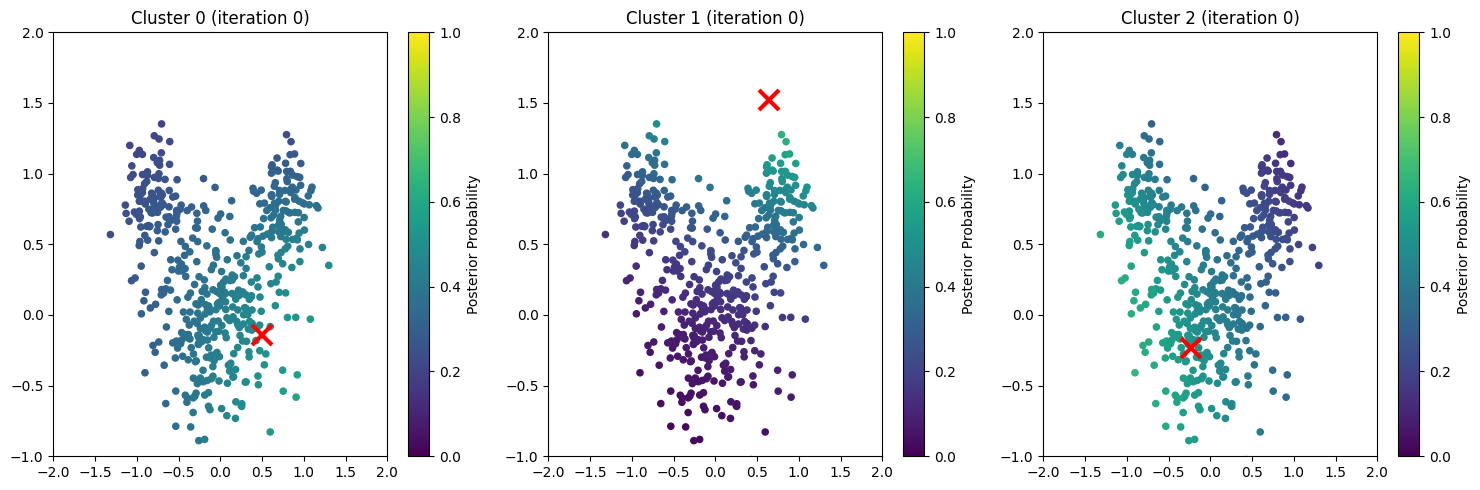

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ----------------------------------------------------------------------
# SECTION 1: Generate the "mouse" dataset
# ----------------------------------------------------------------------
np.random.seed(0)  # for reproducibility

# 1) 300 points from N([0, 0], [[0.16, 0],[0, 0.16]])
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# 2) 100 points from N([0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 3) 100 points from N([-0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine all data
data_X = np.vstack([data1, data2, data3])
N, d = data_X.shape  # should be (500, 2)

# ----------------------------------------------------------------------
# SECTION 2: Initialize EM for 3 Gaussian mixtures
# ----------------------------------------------------------------------
K = 3
np.random.seed(42)  # again for reproducibility

# Mixture weights, means, covariances
pi = np.ones(K) / K
mu = np.random.randn(K, d)
Sigma = np.array([np.eye(d) for _ in range(K)])

# ----------------------------------------------------------------------
# SECTION 3: Define functions for E-step & M-step
# ----------------------------------------------------------------------
def gaussian_pdf(x, mean, cov):
    """
    Compute multivariate Gaussian pdf value at x, given mean and cov.
    x is (d, ) vector, mean is (d, ), cov is (d, d).
    """
    d_ = len(x)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / np.sqrt((2*np.pi)**d_ * det_cov)
    diff = x - mean
    exponent = -0.5 * (diff @ inv_cov @ diff.T)
    return norm_const * np.exp(exponent)

def e_step(data, pi, mu, Sigma):
    """
    E-step: compute the responsibilities resp[n, k] = p(z_n=k | x_n, theta).
    """
    N, _ = data.shape
    K = len(pi)
    resp = np.zeros((N, K))

    for n in range(N):
        for k in range(K):
            resp[n, k] = pi[k] * gaussian_pdf(data[n], mu[k], Sigma[k])
        resp[n, :] /= np.sum(resp[n, :])  # normalize

    return resp

def m_step(data, resp):
    """
    M-step: given responsibilities, update pi, mu, Sigma.
    """
    N, d_ = data.shape
    K = resp.shape[1]

    Nk = np.sum(resp, axis=0)  # shape (K,)

    # Update pi
    pi_new = Nk / N

    # Update mu
    mu_new = np.zeros((K, d_))
    for k in range(K):
        mu_new[k] = np.sum(resp[:, k].reshape(-1,1)*data, axis=0) / Nk[k]

    # Update Sigma
    Sigma_new = []
    for k in range(K):
        S_k = np.zeros((d_, d_))
        for n in range(N):
            diff = data[n] - mu_new[k]
            S_k += resp[n, k] * np.outer(diff, diff)
        S_k /= Nk[k]
        Sigma_new.append(S_k)
    Sigma_new = np.array(Sigma_new)

    return pi_new, mu_new, Sigma_new

# ----------------------------------------------------------------------
# SECTION 4: Set up for animation - plot the initial state
# ----------------------------------------------------------------------
# We'll store the EM parameters in global variables so we can update them
# within our animation function easily.

# Precompute figure, axes, and placeholders for scatter plots and cluster centers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# We'll create one scatter per cluster:
scatters = []
center_plots = []

# Initialize the responsibilities (before first iteration) just for plotting the colors
resp_init = e_step(data_X, pi, mu, Sigma)

for k in range(K):
    # Scatter for the data with color = responsibilities for cluster k
    sc = axes[k].scatter(data_X[:, 0], data_X[:, 1],
                         c=resp_init[:, k], cmap='viridis',
                         s=20, vmin=0, vmax=1)

    scatters.append(sc)

    # Plot for the cluster center: "X" in red
    cp, = axes[k].plot(mu[k,0], mu[k,1], 'rx', markersize=14, mew=3)
    center_plots.append(cp)

    axes[k].set_title(f'Cluster {k} (iteration 0)')
    axes[k].set_xlim([-2, 2])
    axes[k].set_ylim([-1, 2])

    # Add a colorbar for each subplot
    cbar = fig.colorbar(sc, ax=axes[k])
    cbar.set_label('Posterior Probability')

plt.tight_layout()
plt.show()



In [ ]:
iterations = 60  # number of EM iterations (frames in the animation)
    #In 60 iterations the EM converges

# ----------------------------------------------------------------------
# SECTION 5: Define the update function for animation
# ----------------------------------------------------------------------
def init():
    # Nothing special needed for init
    return scatters + center_plots

def animate(frame):
    global pi, mu, Sigma

    # Perform one E-step + M-step
    resp = e_step(data_X, pi, mu, Sigma)
    pi, mu, Sigma = m_step(data_X, resp)

    # Update the scatter colors & cluster center positions
    for k in range(K):
        # update scatter color array
        scatters[k].set_array(resp[:, k])
        # update center plot
        center_plots[k].set_data([mu[k,0]], [mu[k,1]])
        axes[k].set_title(f'Cluster {k} (iteration {frame+1})')
    return scatters + center_plots

anim = FuncAnimation(fig, animate, frames=iterations,
                     init_func=init, blit=False, interval=120)

# ----------------------------------------------------------------------
# SECTION 6: Display the animation
# ----------------------------------------------------------------------
# If you're in a Jupyter/Colab environment, you can display the animation inline:
HTML(anim.to_html5_video())

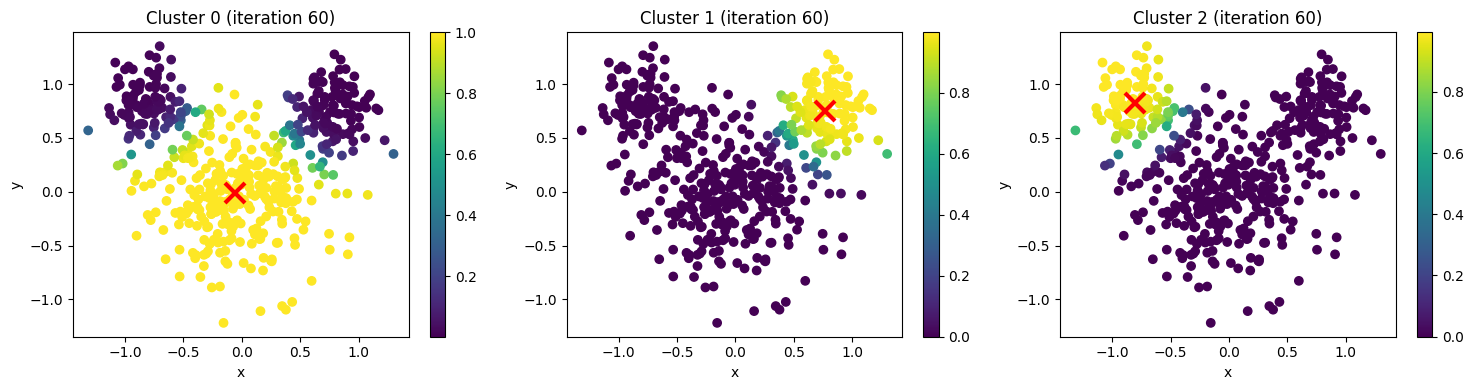

In [ ]:
# ----------------------------------------------------------------------
# SECTION 7: plot the final state
# ----------------------------------------------------------------------
resp_final = e_step(data_X, pi, mu, Sigma)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for k in range(K):
    sc = axes[k].scatter(data_X[:,0], data_X[:,1], c=resp_final[:, k], cmap='viridis')
    axes[k].set_title(f'Cluster {k} (iteration {iterations})')
    axes[k].set_xlabel('x')
    axes[k].set_ylabel('y')
    # Plot for the cluster center: "X" in red
    cp = axes[k].plot(mu[k,0], mu[k,1], 'rx', markersize=14, mew=3)
    # Add a colorbar
    plt.colorbar(sc, ax=axes[k])

plt.tight_layout()
plt.show()

## Why do some points far from the cluster center have higher probability in initial iteration than some points at the cluster center (this is especialy true for cluster 2)?

The short answer is that **the initial cluster centers and covariance matrices are random guesses** and do *not* yet align with the true data distribution. When you see surprising assignments (points far from the center getting higher probability than points near it), it’s usually because:

1. **Random Initialization**  
   The means (cluster centers) $\mu_k$ are set randomly (e.g. `np.random.randn`) and the covariances $\Sigma_k$ might start as identity matrices. Hence, there's no reason to expect the initial guesses to match the real shape or location of your data clusters. The center “X” you see is just a random starting guess.

2. **Equal Mixture Weights & Identity Covariances**  
   Initially, each cluster $k$ has an identical mixture weight $\pi_k = 1/K$ and the same covariance $\Sigma_k = I$. If the random $\mu_k$ happens to lie outside or on the edge of the data distribution, the Gaussian “footprint” (with identity covariance) might still assign *moderately high* likelihood to points that are not necessarily the *closest* in Euclidean distance. The posterior responsibility formula is
   $$
   \gamma_{n,k}
   \;=\;
   \frac{\pi_k \, \mathcal{N}(x_n \mid \mu_k, \Sigma_k)}
        {\sum_{j=1}^{K} \pi_j \, \mathcal{N}(x_n \mid \mu_j, \Sigma_j)}.
   $$
   Because $\pi_k$ and $\Sigma_k$ are the same across clusters in iteration 0, small details in how the random $\mu_k$ are placed can lead to unintuitive “which cluster gets higher probability” for a given $x_n$.

3. **No Guarantee the “Brightest” Points are Nearest**  
   You might expect that “closer to the mean $\implies$ higher probability.” But in iteration 0, if two cluster centers $\mu_k$ and $\mu_{k'}$ are randomly scattered, the relative difference in distances (and direction in a 2D plane) can make a point that is moderately far from $\mu_k$ *still* more likely under that cluster than a point that’s near $\mu_{k'}$, purely because the denominators and normalizations shape the posterior probabilities in a somewhat counter-intuitive way at first.

4. **Over Iterations, Convergence Corrects This**  
   Once you run further EM iterations, the means $\mu_k$ move to center themselves on their respective subsets of the data, the covariances $\Sigma_k$ adapt, and the mixture weights $\pi_k$ adjust to reflect cluster sizes. Eventually, data points near each mean will have the highest probability for that cluster, as your final solution aligns with the actual data distribution. The odd initial assignments are simply a byproduct of the random starting point.

Hence, it’s normal to see “weird” cluster assignment patterns in iteration 0. EM will correct this behavior in subsequent iterations, and you’ll see that the cluster centers and posterior probabilities start matching your intuitive notion of “points nearest the center get the highest probability” after a few updates.


**In the case of cluster 2 in the plots above, the X marker for cluster 0 is relatively close, and the variances of the clusters "overlap," causing points near the X marker for cluster 2 to also have a high probability of belonging to cluster 0. As a result, these points appear less bright compared to points farther away that belong exclusively to cluster 2 with high certainty. This occurs because the membership likelihood in a nearby cluster (cluster 0) decreases quadratically with distance.**


# Vanilla* K-Means Algorithm
--------------------------------

<small><small><small>[* In the context of algorithms or technology, the term **vanilla** refers to something in its basic, unmodified, or standard form, without any special additions, customizations, or enhancements. It is derived from the perception of vanilla as a "plain" or "default" flavor in food, particularly **ice cream**.]</small></small></small>

The K-Means algorithm is a method for clustering points in a Euclidean space $\mathbb{R}^d$. **The Euclidean space assumption is very strong but it is necessary for the algorithm.** The algorithm works as follows:

- **Random Initialization**: Randomly create $k$ centroids, which are points in the space $\mathbb{R}^d$.
- **Assignment Step**: Assign each data point to the nearest centroid based on the Euclidean distance.
- **Update Step**: Recompute each centroid's position as the mean of all points assigned to it.
- **Repeat**: Assignment and Update steps are repeated iteratively until convergence, typically when the centroids stabilize or the improvement in clustering quality becomes negligible.

## Relation to EM clustering

K-means clustering can be viewed as a special, simplified case of the EM algorithm for a Gaussian mixture model (GMM). In particular, if we assume **all covariance matrices in the mixture are spherical and share the same fixed variance**, and if the variance is very small, then the EM algorithm’s E-step reduces to assigning each data point to the nearest cluster center (just like K-means), and the M-step collapses to updating each cluster center by taking the mean of the assigned points. Thus, K-means can be interpreted as performing EM on a GMM under strong simplifying assumptions (identical spherical covariances with fixed small variance and hard assignments instead of soft responsibilities), which is why K-means is often considered an instance of EM with constrained parameters.

The sparse centers are required because in K-means a point is **hard-assigned** to a given cluster, whereas in EM the responsibilities are probabilities effectively **soft-assigning** points to clusters.


We do not explicitly estimate the variances in K-Means. As a result, the clusters identified by K-Means cannot be used to generate new data. In contrast, EM clustering can be considered a generative model, as it estimates parameters that allow data generation based on the underlying distribution.



## Key Properties of K-Means

The K-Means algorithm has the following properties:

- It **requires** Euclidean distance is used as the distance measure.
- It tends to divide the dataset into clusters of roughly equal size (recall: all covariance matrices in the mixture are spherical and share the same fixed variance).
- Thanks for computing the centroids, it has relatively low computational complexity, making it efficient for large datasets.

## Inertia (Within Cluster SS) Local Minimization

At each update step, the algorithm locally reduces the Inertia measure, which evaluates the compactness of clusters. To understand this, observe that in Euclidean space, the Sum of Squares is minimized when the point is located at the centroid of the cluster.

The assignment step ensures that each point is assigned to its nearest centroid, while the update step recalculates centroids to minimize the sum of squared distances for points within each cluster. This iterative process leads to a local minimum of the Inertia measure.

In a variant of the K-Means algorithm, the process can be restarted multiple times with different initializations. Among the results, the one corresponding to the best local minimum (i.e. the one with the lowest Inertia value) is selected and reported.

## K-Medoids Algorithm

The K-Medoids algorithm is another noteworthy variant of K-Means. It drops the requirement for the data to be Euclidean (with the price of increased computationall complexity). Instead of using centroids, it selects medoids, which are actual observations from the dataset representing the cluster centers.

- **Random Initialization**: Randomly select $k$ observations as medoids.
- **Assignment Step**: Assign each data point to the nearest medoid.
- **Update Step**: Iteratively replace a medoid with another observation and check whether the total distance between points and their nearest medoids decreases.
- **Repeat**: Assignment and Update steps are repeated until no further improvement is possible.


### Key Properties of K-Medoids

The K-Medoids algorithm has the following properties:

- It allows the use of any distance metric, not just Euclidean distance.
- Finding the medoid for each cluster requires comparing distances between all points within the cluster. This process is computationally more complex than calculating the centroid, which is simply the mean of the points. As a result, the overall **computational complexity of K-Medoids is higher than that of vanilla K-Means**.

**The medoids are always actual observations from the dataset, unlike centroids in K-Means.**


# Experimenting with the *mouse* dataset
--------------------------------------------

We will run the library versions of K-Means, K-Medoids and EM for the *mouse* dataset. We will compare the results and the running times.

In [ ]:
pip install scikit-learn-extra   #it is required for K-Medoids algorithm

## Estimating EM, K-Means, K-Medoids

Average runtime over 5 runs:
  - GaussianMixture (EM) : 0.01491 s
  - KMeans              : 0.00316 s
  - KMedoids            : 0.08744 s


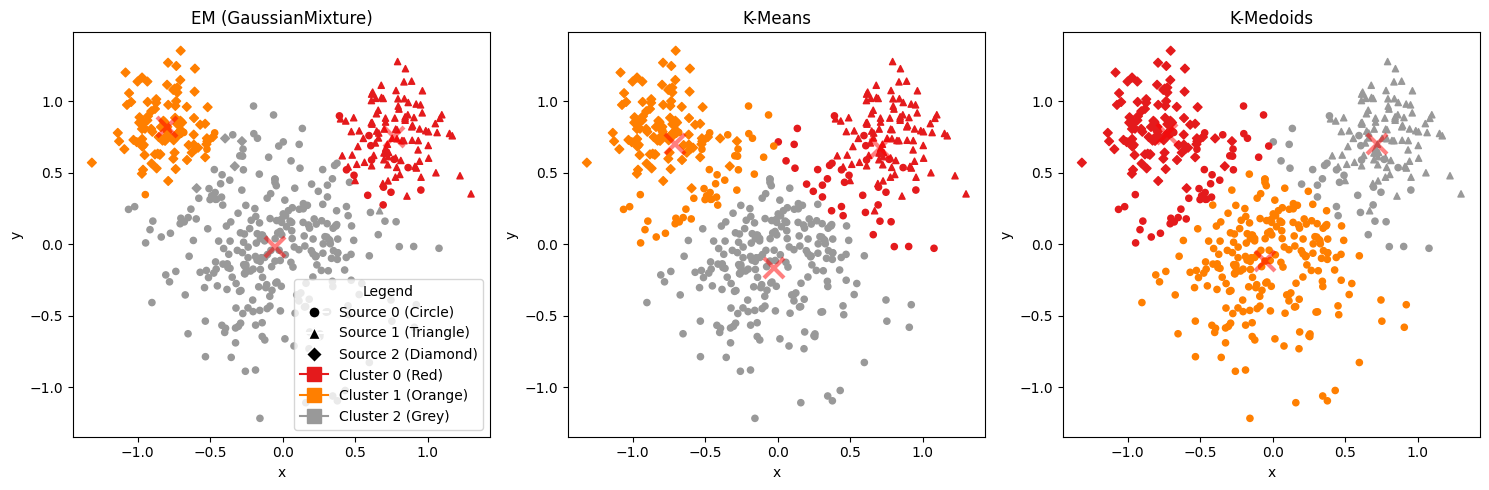

In [ ]:
import time

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D  # Import Line2D for custom legend

# ----------------------------------------------------------------------
# SECTION 1: Define a helper function to measure runtime
# ----------------------------------------------------------------------
def measure_runtime(model_class, X, n_runs=5, **kwargs):
    """
    Instantiates and fits `model_class(**kwargs)` on X `n_runs` times.
    Returns average runtime across those runs (in seconds).
    """
    start = time.time()
    for _ in range(n_runs):
        model = model_class(**kwargs)
        model.fit(X)
    end = time.time()
    return (end - start)/n_runs, model

# ----------------------------------------------------------------------
# SECTION 2: Measure runtime for each algorithm + final fit for plotting
# ----------------------------------------------------------------------
n_runs = 5  # number of runs to average the runtime

# EM for Gaussian Mixtures
gm_time, gm_model = measure_runtime(GaussianMixture, data_X, n_runs=n_runs, n_components=3, covariance_type='full', random_state=42)
gm_labels = gm_model.predict(data_X)

# K-means
km_time, km_model = measure_runtime(KMeans, data_X, n_runs=n_runs, n_clusters=3, random_state=42)
km_labels = km_model.labels_

# K-medoids
kmed_time, kmed_model = measure_runtime(KMedoids, data_X, n_runs=n_runs, n_clusters=3, random_state=42, method='pam')
kmed_labels = kmed_model.labels_

print(f"Average runtime over {n_runs} runs:")
print(f"  - GaussianMixture (EM) : {gm_time:.5f} s")
print(f"  - KMeans              : {km_time:.5f} s")
print(f"  - KMedoids            : {kmed_time:.5f} s")

# ----------------------------------------------------------------------
# SECTION 3: Plot each clustering's results
# ----------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
data_counts = [300, 100, 100]  # Number of points per source
markers = ['o', '^', 'D']  # Circle, Triangle, Diamond


# Define markers for each data source
markers = ['o', '^', 'D']  # Circle, Triangle, Diamond
data_counts = [300, 100, 100]
# Create a normalizer to scale cluster labels to colormap range
norm = Normalize(vmin=0, vmax=2)  # Normalize colors between 0 and 2

start = 0
# EM (GaussianMixture)
for original_group in range(3):
  end = start + data_counts[original_group]
  axes[0].scatter(data_X[start:end,0], data_X[start:end,1], c=gm_labels[start:end], marker=markers[original_group], cmap='Set1', s=20, norm=norm)
  start = end

axes[0].plot(gm_model.means_[:, 0], gm_model.means_[:, 1], 'rx', markersize=14, mew=3, alpha=0.5)
axes[0].set_title("EM (GaussianMixture)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

start = 0
# K-Means
for original_group in range(3):
  end = start + data_counts[original_group]
  axes[1].scatter(data_X[start:end,0], data_X[start:end,1], c=km_labels[start:end], marker=markers[original_group], cmap='Set1', s=20, norm=norm)
  start = end

axes[1].plot(km_model.cluster_centers_[:, 0], km_model.cluster_centers_[:, 1], 'rx', markersize=14, mew=3, alpha=0.5)
axes[1].set_title("K-Means")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

start = 0
# K-Medoids
for original_group in range(3):
  end = start + data_counts[original_group]
  axes[2].scatter(data_X[start:end,0], data_X[start:end,1], c=kmed_labels[start:end], marker=markers[original_group], cmap='Set1', s=20, norm=norm)
  start = end

axes[2].plot(kmed_model.cluster_centers_[:, 0], kmed_model.cluster_centers_[:, 1], 'rx', markersize=14, mew=3, alpha=0.5)
axes[2].set_title("K-Medoids")
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")


legend_elements = [
    # Markers for original data sources
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, label='Source 0 (Circle)'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markersize=8, label='Source 1 (Triangle)'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='k', markersize=8, label='Source 2 (Diamond)'),

    # Colors for inferred clusters
    Line2D([0], [0], marker='s', color=plt.cm.Set1(0.0), markersize=10, label='Cluster 0 (Red)'),
    Line2D([0], [0], marker='s', color=plt.cm.Set1(0.5), markersize=10, label='Cluster 1 (Orange)'),
    Line2D([0], [0], marker='s', color=plt.cm.Set1(1.0), markersize=10, label='Cluster 2 (Grey)')
]

# Add legend to the plot
axes[0].legend(handles=legend_elements, loc='best', frameon=True, title="Legend")

plt.tight_layout()
plt.show()


## Generating data from EM

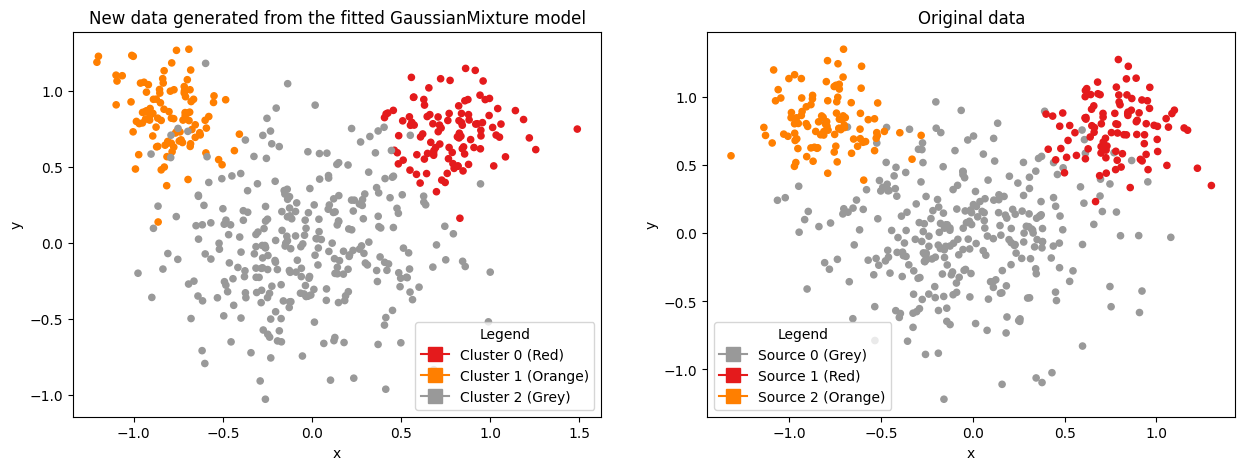

In [ ]:
norm = Normalize(vmin=0, vmax=2)  # Normalize colors between 0 and 2 - common color pallette

# 1. Generate 500 new points from the fitted GM model
X_new, new_labels = gm_model.sample(n_samples=500)

# 2. Visualize the newly generated data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(X_new[:, 0], X_new[:, 1], c=new_labels, cmap='Set1', s=20, norm=norm)
axes[0].set_title("New data generated from the fitted GaussianMixture model")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
legend_elements = [
    Line2D([0], [0], marker='s', color=plt.cm.Set1(0.0), markersize=10, label='Cluster 0 (Red)'),
    Line2D([0], [0], marker='s', color=plt.cm.Set1(0.5), markersize=10, label='Cluster 1 (Orange)'),
    Line2D([0], [0], marker='s', color=plt.cm.Set1(1.0), markersize=10, label='Cluster 2 (Grey)')
]

# Add legend to the plot
axes[0].legend(handles=legend_elements, loc='best', frameon=True, title="Legend")

# 3. Visualize the original data

axes[1].scatter(data_X[:, 0], data_X[:, 1], c=[2]*300+[0]*100+[1]*100, cmap='Set1', s=20, norm=norm)  #I shuffle the colors to match the inferred clusters
axes[1].set_title("Original data")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
legend_elements = [
    Line2D([0], [0], marker='s', color=plt.cm.Set1(1.0), markersize=10, label='Source 0 (Grey)'),
    Line2D([0], [0], marker='s', color=plt.cm.Set1(0.0), markersize=10, label='Source 1 (Red)'),
    Line2D([0], [0], marker='s', color=plt.cm.Set1(0.5), markersize=10, label='Source 2 (Orange)')
]

# Add legend to the plot
axes[1].legend(handles=legend_elements, loc='best', frameon=True, title="Legend")


plt.show()

## Generating from K-Means (?)

Explain, why the code below fails to execute

In [ ]:
# Generate 500 new points from the fitted K-means model
X_new, new_labels = km_model.sample(n_samples=500)

AttributeError: 'KMeans' object has no attribute 'sample'

# **Homework Assignment: EM Clustering in 2D**
-------------------------------

You have seen how the **Expectation-Maximization (EM)** algorithm can fit a Gaussian Mixture Model (GMM) to a 2D dataset. You should now explore:

## **Primary Question**

**How can we visualize the *decision boundary* for attributing a *new* (unlabeled) point to one of the GMM clusters?**  

In other words, given a 2D data distribution modeled by EM, think of a way to clearly show (on a plot) *which* cluster a point would be assigned to (or which cluster has the highest responsibility (posterior probability) for that point)?  

The plot should comprehensively cover the entire visible region, ensuring that for any point on the plot, it is immediately evident which cluster it would belong to. You can plot **lines** separating clusters or use a **color map** showing each point's "most likely cluster".

You can illustrate your approach with **the same** 2D dataset that we used in class, or you can find another suitable 2D dataset, it's up to you. Note however, that having 3 clusters enhances the clarity of the visualization—while 2 clusters result in overly simple boundaries, using 4 or more clusters can make the entire plot difficult to interpret. Try to choose a dataset with 3 clusters.

Discuss any irregularities observed in the resulting plot. If a decision boundary suggests that a region should be attributed to a cluster in a counterintuitive way (we saw it in class!), provide an explanation for why this might occur. It may be also an indication you have a bug in your code.

## **Secondary Question**

**If we *didn't know* the number of clusters in advance, how could we decide on a suitable $K$ for the clustering algorithm?**  

You can illustrate your approach with **the same** dataset as in the primary question by trying different values of $K$ (and optionally plotting the evaluation metric values, e.g. silhouette scores, etc.). Or you can find another suitable dataset, it's up to you. Note, that the dataset doesn't need to be 2D in this task.

## **Task & Deliverables**

1. **Colab Notebook**  
   - Create a **Colab notebook** that:
     - Clearly **answers** both the **primary** and **secondary** questions with appropriate plots and short explanations.
     - Uses Python code (e.g. `scikit-learn` for GMM) to visualize:
       1. The **data** and **cluster assignments**.
       2. The **decision boundary** (lines or a color map) indicating each cluster's region.
       3. A demonstration (chart or table) of how you would pick a suitable number of clusters $K$ when it is not known.
   - Remember to use the `$` symbol to delimit **inline equations** and `$$` to delimit **full-line equations**.

2. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ----------------------------------------------------------------------
# SECTION 1: Generate the "mouse" dataset
# ----------------------------------------------------------------------
np.random.seed(0)  # for reproducibility

# 1) 300 points from N([0, 0], [[0.16, 0],[0, 0.16]])
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# 2) 100 points from N([0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 3) 100 points from N([-0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine all data
data_X = np.vstack([data1, data2, data3])
N, d = data_X.shape  # should be (500, 2)

# ----------------------------------------------------------------------
# SECTION 2: Initialize EM for 3 Gaussian mixtures
# ----------------------------------------------------------------------
K = 3
np.random.seed(42)  # again for reproducibility

# Mixture weights, means, covariances
pi = np.ones(K) / K
mu = np.random.randn(K, d)
Sigma = np.array([np.eye(d) for _ in range(K)])

# ----------------------------------------------------------------------
# SECTION 3: Define functions for E-step & M-step
# ----------------------------------------------------------------------
def gaussian_pdf(x, mean, cov):
    """
    Compute multivariate Gaussian pdf value at x, given mean and cov.
    x is (d, ) vector, mean is (d, ), cov is (d, d).
    """
    d_ = len(x)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / np.sqrt((2*np.pi)**d_ * det_cov)
    diff = x - mean
    exponent = -0.5 * (diff @ inv_cov @ diff.T)
    return norm_const * np.exp(exponent)

def e_step(data, pi, mu, Sigma):
    """
    E-step: compute the responsibilities resp[n, k] = p(z_n=k | x_n, theta).
    """
    N, _ = data.shape
    K = len(pi)
    resp = np.zeros((N, K))

    for n in range(N):
        for k in range(K):
            resp[n, k] = pi[k] * gaussian_pdf(data[n], mu[k], Sigma[k])
        resp[n, :] /= np.sum(resp[n, :])  # normalize

    return resp

def m_step(data, resp):
    """
    M-step: given responsibilities, update pi, mu, Sigma.
    """
    N, d_ = data.shape
    K = resp.shape[1]

    Nk = np.sum(resp, axis=0)  # shape (K,)

    # Update pi
    pi_new = Nk / N

    # Update mu
    mu_new = np.zeros((K, d_))
    for k in range(K):
        mu_new[k] = np.sum(resp[:, k].reshape(-1,1)*data, axis=0) / Nk[k]

    # Update Sigma
    Sigma_new = []
    for k in range(K):
        S_k = np.zeros((d_, d_))
        for n in range(N):
            diff = data[n] - mu_new[k]
            S_k += resp[n, k] * np.outer(diff, diff)
        S_k /= Nk[k]
        Sigma_new.append(S_k)
    Sigma_new = np.array(Sigma_new)

    return pi_new, mu_new, Sigma_new

for i in range(100):
      resp = e_step(data_X, pi, mu, Sigma)
      pi, mu, Sigma = m_step(data_X, resp)


In [ ]:
x=np.linspace(-1.5,1.5,500)
y=np.linspace(-1.5,1.5,500)
X,Y=np.meshgrid(x,y)
resps=[]

for i in range(K):
  Z=np.zeros([len(y),len(x)])
  for j in range(len(x)):
    for k in range(len(y)):
      Z[k,j]=pi[i] *gaussian_pdf(np.array([x[j],y[k]]), mu[i], Sigma[i])
  resps.append(Z)


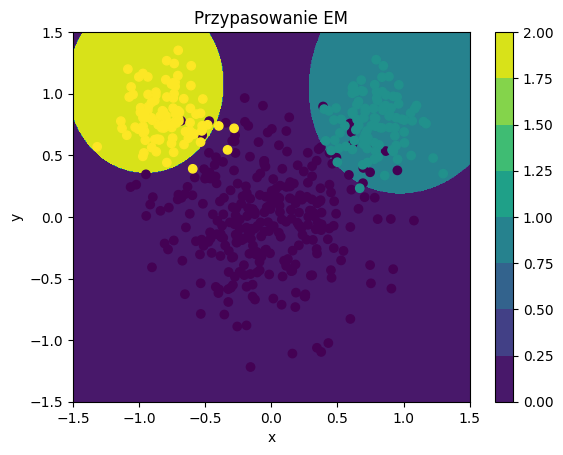

In [ ]:
przypasowanie=np.argmax(resps,axis=0)
prawda=[0]*300+[1]*100+[2]*100
plt.contourf(X,Y,przypasowanie)
plt.colorbar()
plt.scatter(data_X[:,0],data_X[:,1],c=prawda,cmap='viridis')
plt.title('Przypasowanie EM')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Question 2

We will perform for mouse data 2 types of clusstering: EM and KMeans for 2-7 clusters and we will look at silhouett scores and inertias to determine which number of clusters is best.

### EM

In [9]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

def inertia(data, labels, centroids):
    distances = pairwise_distances(data, centroids)
    min_distances = np.min(distances, axis=1)
    return np.sum(min_distances**2)


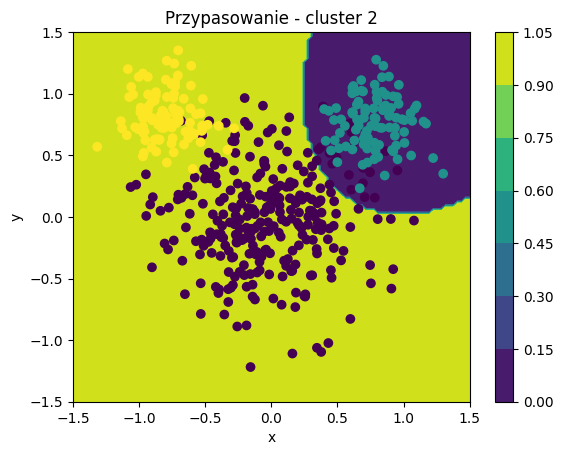

Silhouette score:  0.40890256209377435
Inertia:  186.76047427914773


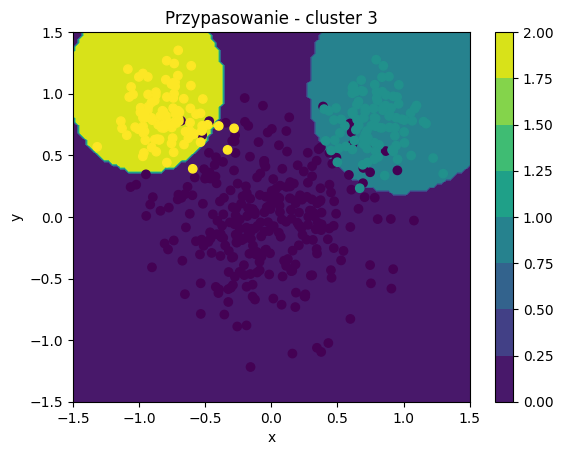

Silhouette score:  0.4631361544986543
Inertia:  89.56313737046148


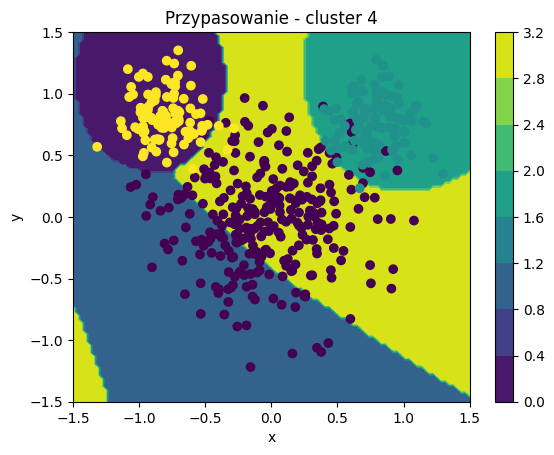

Silhouette score:  0.40052962444089235
Inertia:  68.94829679231009


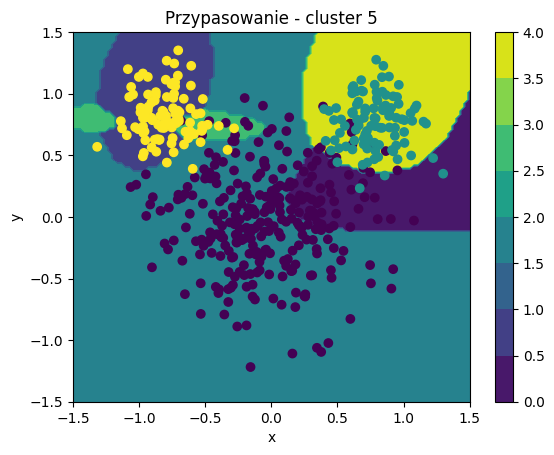

Silhouette score:  0.23430217436356862
Inertia:  67.66849549720249


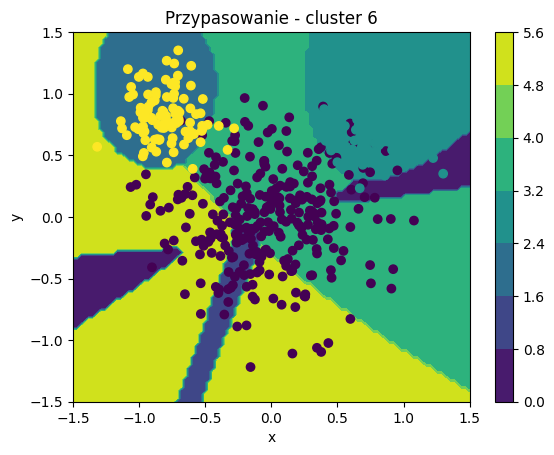

Silhouette score:  0.28782623275254293
Inertia:  61.191834469579156


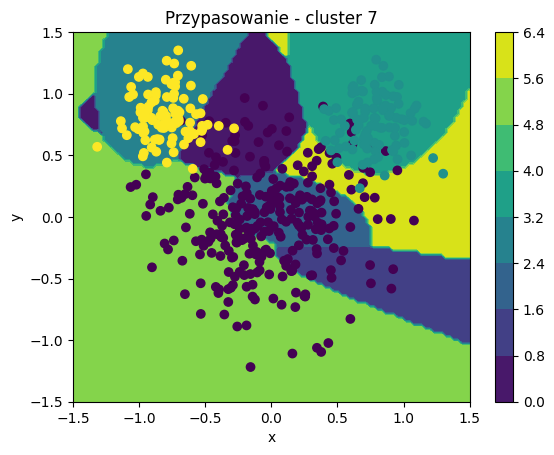

Silhouette score:  0.2961323504464106
Inertia:  43.63083626355983


In [ ]:
Ks=range(2,8)
sllhouetts=[]
inertias=[]

for K in Ks:
  pi = np.ones(K) / K
  mu = np.random.randn(K, d)
  Sigma = np.array([np.eye(d) for _ in range(K)])
  for i in range(100):
      resp = e_step(data_X, pi, mu, Sigma)
      pi, mu, Sigma = m_step(data_X, resp)


  x=np.linspace(-1.5,1.5,100)
  y=np.linspace(-1.5,1.5,100)
  X,Y=np.meshgrid(x,y)
  resps=[]

  for i in range(K):
    Z=np.zeros([len(y),len(x)])
    for j in range(len(x)):
      for k in range(len(y)):
        Z[k,j]=pi[i] *gaussian_pdf(np.array([x[j],y[k]]), mu[i], Sigma[i])
    resps.append(Z)

  przypasowanie=np.argmax(resps,axis=0)
  prawda=[0]*300+[1]*100+[2]*100
  plt.contourf(X,Y,przypasowanie)
  plt.colorbar()
  plt.scatter(data_X[:,0],data_X[:,1],c=prawda,cmap='viridis')
  plt.title('Przypasowanie - cluster '+str(K))
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()
  klasteryzacja=np.argmax(resp,axis=1)
  print('Silhouette score: ', silhouette_score(data_X, klasteryzacja))
  sllhouetts.append(silhouette_score(data_X, klasteryzacja))
  print('Inertia: ', inertia(data_X, klasteryzacja, mu))
  inertias.append(inertia(data_X, klasteryzacja, mu))


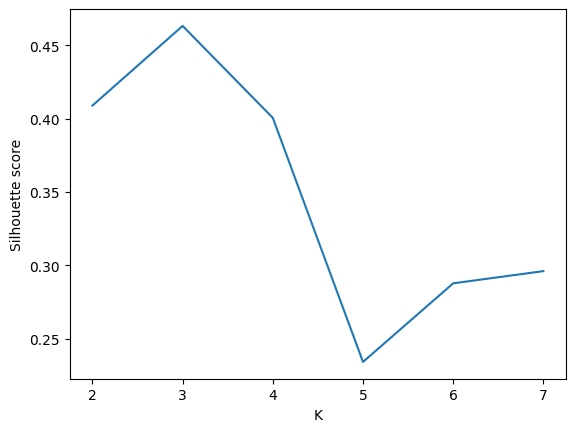

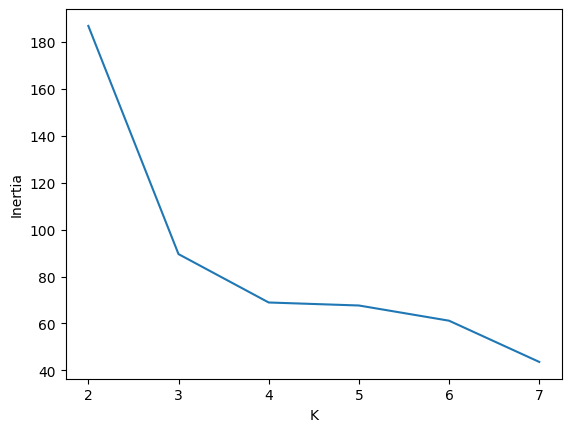

In [ ]:
plt.plot(Ks,sllhouetts)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for EM')
plt.show()

plt.plot(Ks,inertias)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Inertia for EM')
plt.show()

As we can see from plots above the best number of clusters is 3 because it gives the best silhouette score and gives the biggest difference in inertia compared to inertia for 2 clusters.

What is interesting is that for 6 and 7 clusters silhouette scores rise. I think that's because as we can see for 5 clusters second cluster is much bigger and it makes less diversification than 6,7 clusters.

### KMeans

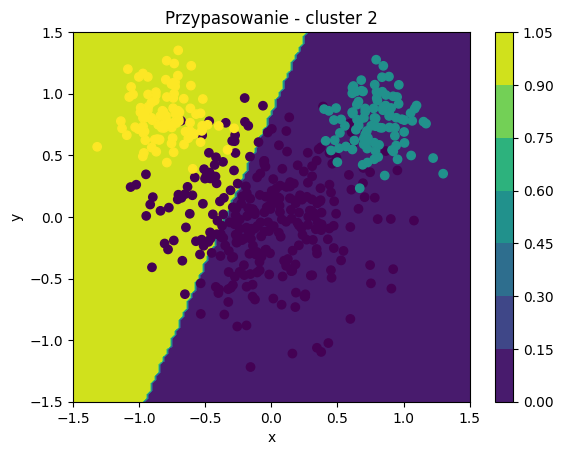

Silhouette score:  0.40010485023311254
Inertia:  184.03241810185096


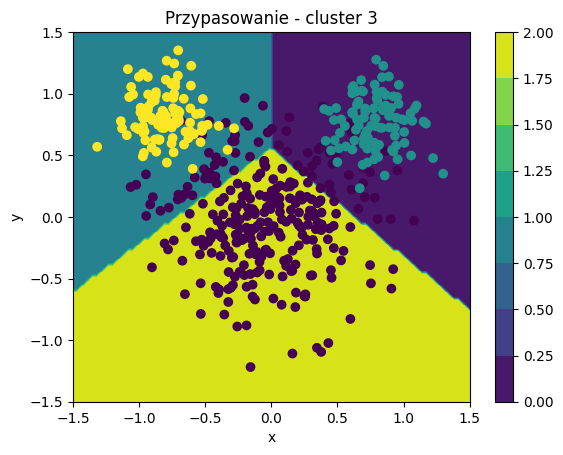

Silhouette score:  0.5152849245204603
Inertia:  82.21576480547022


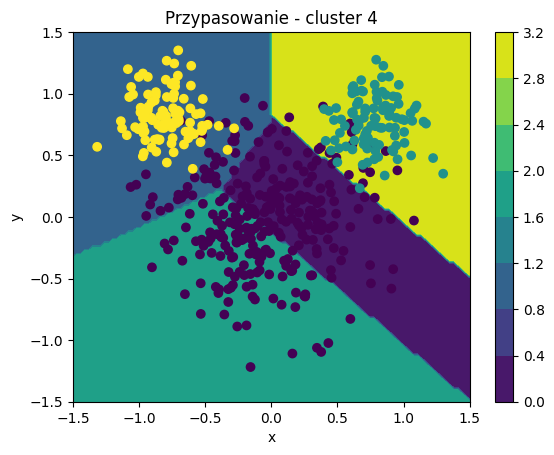

Silhouette score:  0.4499990233162018
Inertia:  63.85233268322616


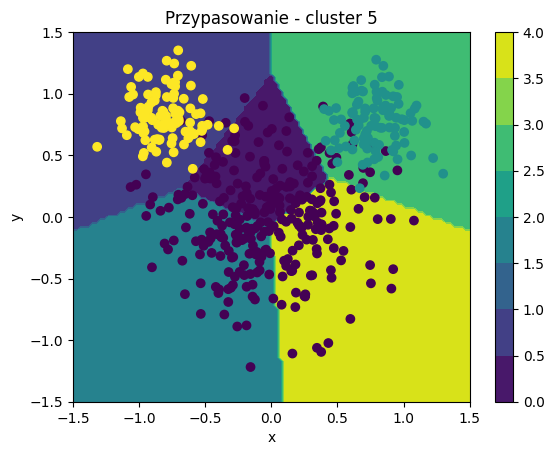

Silhouette score:  0.4381735966786797
Inertia:  52.11876054120289


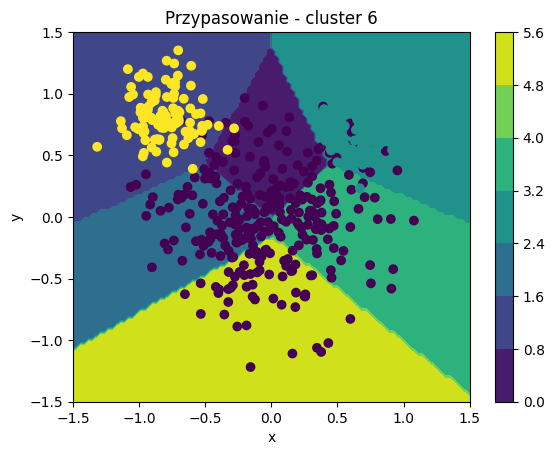

Silhouette score:  0.43322922278213943
Inertia:  43.35172501696859


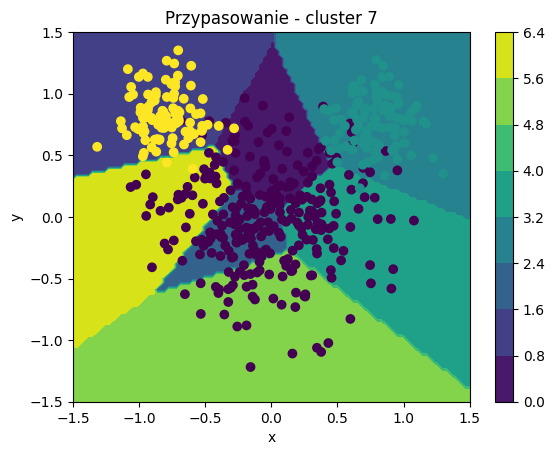

Silhouette score:  0.4220494818689212
Inertia:  38.3964435643728


In [13]:
from sklearn.cluster import KMeans

Ks=range(2,8)
sllhouetts=[]
inertias=[]

for K in Ks:

  km_model = KMeans(n_clusters=K, random_state=42)
  km_model.fit(data_X)
  km_labels = km_model.labels_
  km_centroids = km_model.cluster_centers_


  x=np.linspace(-1.5,1.5,100)
  y=np.linspace(-1.5,1.5,100)
  X,Y=np.meshgrid(x,y)


  grid=np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
  przypasowanie=km_model.predict(grid).reshape(len(y),len(x))

  prawda=[0]*300+[1]*100+[2]*100
  plt.contourf(X,Y,przypasowanie)
  plt.colorbar()
  plt.scatter(data_X[:,0],data_X[:,1],c=prawda,cmap='viridis')
  plt.title('Przypasowanie - cluster '+str(K))
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()
  print('Silhouette score: ', silhouette_score(data_X, km_labels))
  sllhouetts.append(silhouette_score(data_X, km_labels))
  print('Inertia: ', inertia(data_X, km_labels, km_centroids))
  inertias.append(inertia(data_X, km_labels, km_centroids))




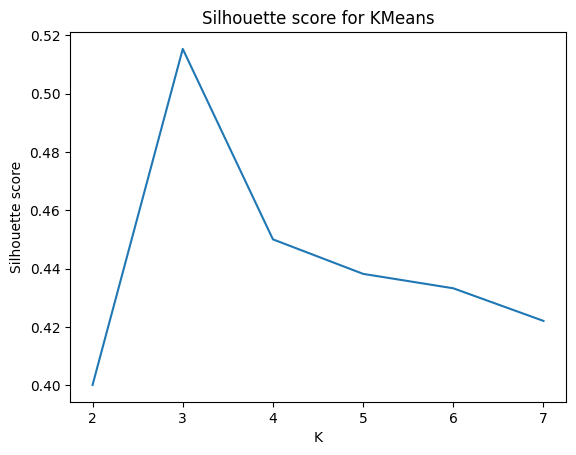

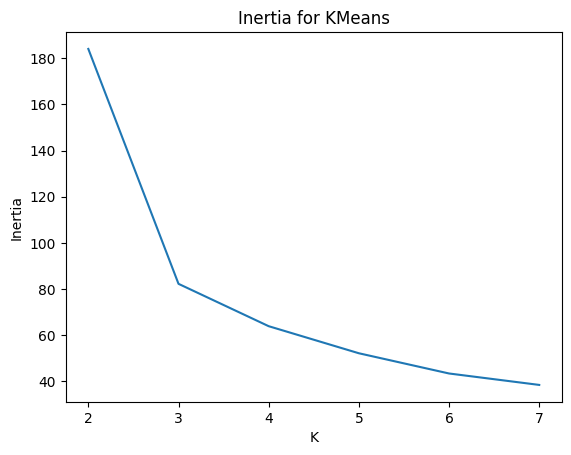

In [15]:
plt.plot(Ks,sllhouetts)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for KMeans')
plt.show()

plt.plot(Ks,inertias)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Inertia for KMeans')
plt.show()

Just like in the EM example we can see that 3 clusters are the best. However we can't see any rise in silhouette score after 3 clusters.